In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa.display
import numpy as np
import datetime
import time
import os
import json
from skimage.transform import resize

from src.data import NSynth
from src.utils import print_and_log
from src.models import Autoencoder

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [3]:
if torch.cuda.is_available():  
    device = torch.device("cuda:0")
else:  
    device = torch.device("cpu") 

In [4]:
hparams = {
    'checkpoint' : None,
    'instrument_source' : [0, 1, 2],
    'sample_rate' : 16000,
    'n_samples' : 64000,
    'feature_type' : 'mel',
    'random_crop' : True,
    'resize' : None,
    'normalize' : True,
    'standardize' : True,
    'standardize_mean' : 0.3356,
    'standardize_std' : 0.2212,
    'spec_augment' : False,
    'remove_synth_lead' : True,
    'n_samples_per_class' : None,
    'n_epochs' : 50,
    'batch_size' : 32,
    'lr' : 0.0001,
    'hidden_dim' : 512,
    'display_iters' : 100,
    'val_iters' : 1000,
    'n_val_samples' : 1000, 
    'n_early_stopping' : 5 # stop if validation doesn't improve after this number of validation cycles
}

In [5]:
train_dataset = NSynth(
    'data/nsynth/nsynth-train', 
    include_meta=False, 
    instrument_source=hparams['instrument_source'], 
    sample_rate=hparams['sample_rate'], 
    n_samples=hparams['n_samples'], 
    feature_type=hparams['feature_type'], 
    random_crop=hparams['random_crop'], 
    resize=hparams['resize'], 
    normalize=hparams['normalize'], 
    standardize=hparams['standardize'], 
    standardize_mean=hparams['standardize_mean'], 
    standardize_std=hparams['standardize_std'], 
    spec_augment=hparams['spec_augment'],
    remove_synth_lead=hparams['remove_synth_lead'], 
    n_samples_per_class=hparams['n_samples_per_class']
)

val_dataset = NSynth(
    'data/nsynth/nsynth-valid', 
    include_meta=False, 
    instrument_source=hparams['instrument_source'], 
    sample_rate=hparams['sample_rate'], 
    n_samples=hparams['n_samples'], 
    feature_type=hparams['feature_type'], 
    random_crop=hparams['random_crop'], 
    resize=hparams['resize'], 
    normalize=hparams['normalize'], 
    standardize=hparams['standardize'], 
    standardize_mean=hparams['standardize_mean'], 
    standardize_std=hparams['standardize_std'], 
    remove_synth_lead=hparams['remove_synth_lead']
)

In [6]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)

In [7]:
model = Autoencoder(h_dim=hparams['hidden_dim'], sigmoid=(not hparams['standardize'])).to(device)
print('# of parameters : {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# of parameters : 7905025


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'])

In [9]:
timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d-%H%M%S')
results_dir = 'train_results/autoencoder/{}'.format(timestamp)
os.makedirs(results_dir)

with open(os.path.join(results_dir, 'hparams.json'), 'w') as fp:
    json.dump(hparams, fp)

log_file = os.path.join(results_dir, 'train_log.txt')
log = open(log_file, 'w')
log.close()
print_and_log('{} {}'.format(train_dataset.__class__.__name__, model.__class__.__name__), log_file)

for k, v in hparams.items(): print_and_log('{} : {}'.format(k, v), log_file)

Autoencoder


[0,     1] loss : 6.8635
[0,   100] loss : 0.4480
[0,   200] loss : 0.2391
[0,   300] loss : 0.2265
[0,   400] loss : 0.2092
[0,   500] loss : 0.2297
[0,   600] loss : 0.1757
[0,   700] loss : 0.1275
[0,   800] loss : 0.1695
[0,   900] loss : 0.1640
[0,  1000] loss : 0.1438
[0,  1100] loss : 0.1372
[0,  1200] loss : 0.1622
[0,  1300] loss : 0.1456
[0,  1400] loss : 0.1492
[0,  1500] loss : 0.1484
[0,  1600] loss : 0.1276
[0,  1700] loss : 0.1336
[0,  1800] loss : 0.1096
[0,  1900] loss : 0.1379
[0,  2000] loss : 0.1189
[0,  2100] loss : 0.1173
[0,  2200] loss : 0.1133
[0,  2300] loss : 0.1278
[0,  2400] loss : 0.1338
[0,  2500] loss : 0.0994
[0,  2600] loss : 0.1037
[0,  2700] loss : 0.1427
[0,  2800] loss : 0.1213
[0,  2900] loss : 0.1125
[0,  3000] loss : 0.0973
[0,  3100] loss : 0.1284
[0,  3200] loss : 0.1080
[0,  3300] loss : 0.1008
[0,  3400] loss : 0.0847
[0,  3500] loss : 0.0949
[0,  3600] loss : 0.1261
[0,  3700] loss : 0.1032
[0,  3800] loss : 0.0932
[0,  3900] loss : 0.0753


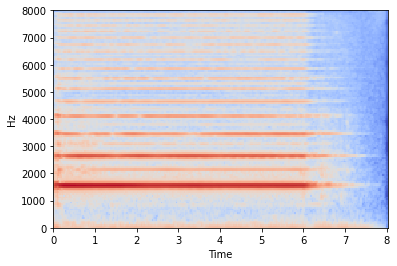

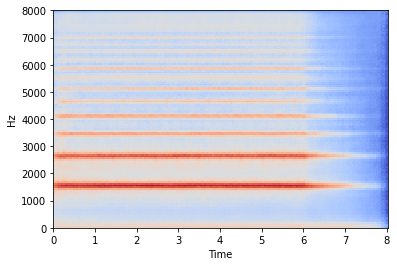

Weights saved in train_results/autoencoder/20200723-231955/model-8866.weights
[1,  8900] loss : 0.0707
[1,  9000] loss : 0.0874
[1,  9100] loss : 0.0457
[1,  9200] loss : 0.0798
[1,  9300] loss : 0.0549
[1,  9400] loss : 0.1202
[1,  9500] loss : 0.0489
[1,  9600] loss : 0.1025
[1,  9700] loss : 0.0497
[1,  9800] loss : 0.0478
[1,  9900] loss : 0.0577
[1, 10000] loss : 0.0496
[1, 10100] loss : 0.0475
[1, 10200] loss : 0.0646
[1, 10300] loss : 0.0527
[1, 10400] loss : 0.0504
[1, 10500] loss : 0.0515
[1, 10600] loss : 0.0875
[1, 10700] loss : 0.0465
[1, 10800] loss : 0.0485
[1, 10900] loss : 0.0486
[1, 11000] loss : 0.0493
[1, 11100] loss : 0.0472
[1, 11200] loss : 0.0441
[1, 11300] loss : 0.0515
[1, 11400] loss : 0.0578
[1, 11500] loss : 0.0459
[1, 11600] loss : 0.0460
[1, 11700] loss : 0.0495
[1, 11800] loss : 0.0570
[1, 11900] loss : 0.0642
[1, 12000] loss : 0.0427
[1, 12100] loss : 0.0472
[1, 12200] loss : 0.0461
[1, 12300] loss : 0.0552
[1, 12400] loss : 0.0654
[1, 12500] loss : 0.04

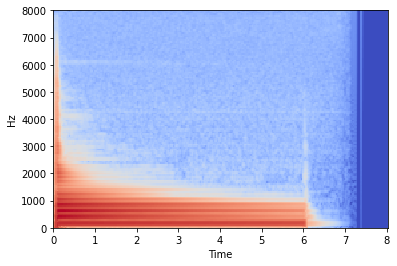

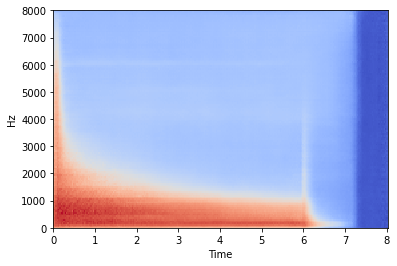

Weights saved in train_results/autoencoder/20200723-231955/model-17732.weights
[2, 17800] loss : 0.0404
[2, 17900] loss : 0.0421
[2, 18000] loss : 0.0328
[2, 18100] loss : 0.0354
[2, 18200] loss : 0.0407
[2, 18300] loss : 0.0391
[2, 18400] loss : 0.0442
[2, 18500] loss : 0.0349
[2, 18600] loss : 0.0440
[2, 18700] loss : 0.0406
[2, 18800] loss : 0.0474
[2, 18900] loss : 0.0467
[2, 19000] loss : 0.0316
[2, 19100] loss : 0.0304
[2, 19200] loss : 0.0352
[2, 19300] loss : 0.0379
[2, 19400] loss : 0.0365
[2, 19500] loss : 0.0316
[2, 19600] loss : 0.0428
[2, 19700] loss : 0.0364
[2, 19800] loss : 0.0449
[2, 19900] loss : 0.0345
[2, 20000] loss : 0.0568
[2, 20100] loss : 0.0363
[2, 20200] loss : 0.0508
[2, 20300] loss : 0.0387
[2, 20400] loss : 0.0431
[2, 20500] loss : 0.0355
[2, 20600] loss : 0.0424
[2, 20700] loss : 0.0380
[2, 20800] loss : 0.0344
[2, 20900] loss : 0.0309
[2, 21000] loss : 0.0382
[2, 21100] loss : 0.0292
[2, 21200] loss : 0.0363
[2, 21300] loss : 0.0367
[2, 21400] loss : 0.0

In [ ]:
if hparams['standardize']:
    loss_fn = nn.MSELoss()
else:
    loss_fn = nn.BCELoss()

ckpt_weights_path = None
best_loss = 1e10
since_best = 0
done = False

if hparams['checkpoint']:
    print_and_log('Resuming training from {}'.format(hparams['checkpoint']), log_file)
    ckpt = torch.load(hparams['checkpoint'])
    epoch = ckpt['epoch']
    itr = ckpt['itr']
    optimizer.load_state_dict(ckpt['optimizer'])
    model.load_state_dict(ckpt['model'])
    best_loss = ckpt['best_loss']
else:
    epoch = 0
    itr = 0

for epoch in range(epoch, hparams['n_epochs']):
    if done:
        break
    
    for batch in train_dataloader:
        if done:
            break
            
        itr += 1
        batch = batch.to(device)
        outputs = model(batch)
        
        loss = loss_fn(outputs, batch)
#         loss = (loss_weighting(batch)*loss).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (itr % hparams['display_iters'] == 0) or (itr == 1):
            print_and_log('[{}, {:5d}] loss : {:.4f}'.format(epoch, itr, loss.item()), log_file)
            
    # validation
    model.eval()
    with torch.no_grad():
        ct, i, val_loss = 0, 0, 0.0
        for batch in val_dataloader:
            i += 1
            ct += batch.size(0)
            batch = batch.to(device)
            outputs = model(batch)

            loss = loss_fn(outputs, batch)
#                     loss = (loss_weighting(batch)*loss).mean()
            val_loss += (loss.item() - val_loss)/i

            if ct >= hparams['n_val_samples']:
                break

    print_and_log('Val - loss : {:.4f}'.format(val_loss), log_file)
    librosa.display.specshow(batch[0][0].cpu().numpy(), sr=16000, x_axis='time', y_axis='hz')
    plt.show()
    librosa.display.specshow(outputs[0][0].detach().cpu().numpy(), sr=16000, x_axis='time', y_axis='hz')
    plt.show()

    if val_loss < best_loss:
        since_best = 0
        best_loss = val_loss

        # save weights
        ckpt_weights_path = os.path.join(results_dir, 'model-{}.weights'.format(itr))
        torch.save(model.state_dict(), ckpt_weights_path)
        print_and_log('Weights saved in {}'.format(ckpt_weights_path), log_file)

        # save meta information
        ckpt_meta_path = os.path.join(results_dir, 'checkpoint')
        torch.save({
            'best_loss' : best_loss,
            'epoch' : epoch,
            'itr' : itr,
            'optimizer' : optimizer.state_dict(),
            'model' : model.state_dict()
        }, ckpt_meta_path)
    else:
        since_best += 1
        if since_best >= hparams['n_early_stopping']:
            done = True
            print_and_log('Early stopping... training complete', log_file)

    model.train()